In [8]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#sns.set(style="ticks")
from scipy import signal
from scipy.optimize import leastsq
from scipy.fft import rfft, rfftfreq
from scipy import signal

from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import math
import csv
from datetime import datetime
from dateutil import parser
from datetime import datetime, timedelta

import os
import glob

Steps to set up CSV format 
- txt --> csv 
- Adjust format (split columns at spaces and tabs)
- new header row/ rename: date, time, red, ir, green, frequency 

In [9]:
#pulse width 69, Sampling Frequency 200
path = '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200'
csv_files = glob.glob(os.path.join(path, "*.csv"))
print(csv_files)

#pulse oximeter
path_po = '/Users/juliapersche/Desktop/PO_arm/PO_arm_69_200'
csv_files_po = glob.glob(os.path.join(path_po, "*.csv"))
print(csv_files_po)

#EKG files 
path_EKG = '/Users/juliapersche/Desktop/EKG_arm/EKG_arm_69_200'
csv_files_EKG = glob.glob(os.path.join(path_EKG, "*.csv"))
print(csv_files_EKG)



['/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm64_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm2_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm5_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm8_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm128_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm3_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm255_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm16_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm4_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm32_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm1_69_200.csv']
['/Users/juliapersche/Desktop/PO_arm/PO_arm_69_200/POarm4_69_200.csv', '/Users/juliapersche/Desktop/PO_arm/PO_ar

In [10]:
#reorder Max30101 csvs in terms of brightness

indices = [10,1,5,8,2,3,7,9,0,4,6]
data = [csv_files[i] for i in indices]
print(data)

#reorder po csvs
indices_po = [3,10,6,0,9,7,1,5,8,4,2]
data_po = [csv_files_po[j] for j in indices_po]

# #reorder EKG csvs
indices_EKG = [9,2,6,10,4,3,8,7,5,1,0]
data_EKG = [csv_files_EKG[b] for b in indices_EKG]
print(data_EKG)


['/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm1_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm2_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm3_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm4_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm5_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm8_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm16_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm32_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm64_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm128_69_200.csv', '/Users/juliapersche/Desktop/Max30101_arm/Max30101_arm_69_200/arm255_69_200.csv']
['/Users/juliapersche/Desktop/EKG_arm/EKG_arm_69_200/EKGarm1_69_200.csv', '/Users/juliapersche/Desktop/EKG_arm/E

test_file = data[0]
test_data = pd.read_csv(test_file)
ms_counter = 0
for idx, row in test_data.iterrows():
    if ms_counter < 10:
        newtime = row['Time'] + ':00' + str(ms_counter)
    if ms_counter < 100:
        newtime = row['Time'] + ':0' + str(ms_counter)
    else:
        newtime = row['Time'] + ':' + str(ms_counter)
    test_data.at[idx, 'Time'] = newtime
    ms_counter += 5
    if ms_counter >= 1000:
        ms_counter = 0

#One Sensor file to epoch (and remove first 20 seconds)

test_file_2 = data[0]
test_data_2 = pd.read_csv(test_file_2)
test_data_2['Timestamp'] = test_data_2['Date'] + " " + test_data_2['Time']
test_data_2['Timestamp']  = (pd.to_datetime(test_data_2['Timestamp'])- pd.Timestamp('1970-01-01')).astype('timedelta64[s]').astype('int')


increments = (1/ (test_data_2['Fs'][0]))*1000
#add_ms = np.arange(0, (len(test_data_2)), (increments))
test_data_2['Timestamp'] = test_data_2['Timestamp']*1000

for idx, row in test_data_2.iterrows():
    #remove first 30 seconds (make sure sync up)
    if idx < 4000: 
     test_data_2.drop(idx,axis=0,inplace=True) 
    
    else:
        #(add_ms[idx])*1000) 
     newtime_2 = ((row['Timestamp']) + (increments * idx)) 
     test_data_2.at[idx, 'Timestamp'] = newtime_2

test_data_2['Timestamp'] = test_data_2['Timestamp'].apply(np.int64)

test_data_2.head(20)


#One EKG Epoch Time and remove first 20 seconds

ekg_test = pd.read_csv('/Users/juliapersche/Desktop/EKG_Max30101_arm/EKGarm5_69_400.csv')

ekg_test['time']= ekg_test['time'].astype(float)
ekg_test['Timestamp'] = ekg_test['time'] * .000001 #to ms
#unsure sampling rate --> what would be 20 seconds? 
ekg_test = ekg_test.drop(range(0,400))

ekg_test.drop('time', axis=1, inplace=True)
ekg_test.head(10)


In [24]:
#sensor files
list_of_dfs = []
Brightness = [1,2,3,4,5,8,16,32,64,128,255]
counter = 0

for f in data:
    k = pd.read_csv(f)
    k['Brightness'] = Brightness[counter]
    k['Timestamp'] = k['Date'] + " " + k['Time']
    k['Timestamp']  = (pd.to_datetime(k['Timestamp'])- pd.Timestamp('1970-01-01')).astype('timedelta64[s]').astype('int')

    fs = k['Fs'][0]
    # drop first ~20 seconds
    k = k.drop(range(0,4000))
    # convert to ms precision
    k['Timestamp']= k['Timestamp']*1000
    
    # offset
    ms_epoch = (1/(fs))*1000
    new_timestamps = []

    for idx, row in k.iterrows():
            newtime_2 = (row['Timestamp']) + (ms_epoch*idx)
            # k.at[idx, 'Timestamp'] = newtime_2
            new_timestamps.append(newtime_2)
    
    k['Timestamp'] = new_timestamps
    #want to try these out
    k['Timestamp'] = k['Timestamp'].apply(np.int64)

   
        

    list_of_dfs.append(k)
    counter += 1

df_max30101_69_200 = pd.concat(list_of_dfs)
# df_max30101_69_200['Timestamp'] = str(df_max30101_69_200['Timestamp'])
# df_max30101_69_200['Timestamp'].replace('16746644', '')

df_max30101_69_200.tail(30)

,Date,Time,Red,IR,Green,Fs,Brightness,Timestamp
82234,2023-02-02,13:42:01,262143,262143,28751,197.59,255,1675345737185
82235,2023-02-02,13:42:01,262143,262143,28772,197.59,255,1675345737190
82236,2023-02-02,13:42:01,262143,262143,28828,197.59,255,1675345737195
82237,2023-02-02,13:42:01,262143,262143,28783,197.59,255,1675345737200
82238,2023-02-02,13:42:01,262143,262143,28788,197.59,255,1675345737205
82239,2023-02-02,13:42:01,262143,262143,28836,197.59,255,1675345737210
82240,2023-02-02,13:42:01,262143,262143,28821,197.59,255,1675345737215
82241,2023-02-02,13:42:01,262143,262143,28781,197.59,255,1675345737220
82242,2023-02-02,13:42:01,262143,262143,28781,197.59,255,1675345737225
82243,2023-02-02,13:42:01,262143,262143,28793,197.59,255,1675345737230


In [23]:
#pulse oximeter files 
list_of_dfs_po = []
Brightness_po = [1,2,3,4,5,8,16,32,64,128,255]
counter_po = 0

for f_po in data_po:
    # read the csv file
    k_po = pd.read_csv(f_po)
    k_po = k_po.drop(range(0,20))
    k_po['Brightness'] = Brightness_po[counter_po]
    k_po['Timestamp'] =  k_po['Timestamp']*1000
        
list_of_dfs_po.append(k_po)
counter_po += 1


df_po_69_200 = pd.concat(list_of_dfs_po)
df_po_69_200.drop('Date', axis=1, inplace=True)
df_po_69_200.drop('Time', axis=1, inplace=True)
df_po_69_200.head()



#EKG files
list_of_dfs_EKG = []
Brightness_EKG = [1,2,3,4,5,8,16,32,64,128,255]
counter_EKG = 0

for f_EKG in data_EKG:
    # read the csv file
    k_EKG = pd.read_csv(f_EKG)
    k_EKG = k_EKG.drop(range(0,20))
    k_EKG['Brightness'] = Brightness_EKG[counter_EKG]
    k_EKG['Timestamp'] =  k_EKG['time']/1000000
    
    #drop all rows where timestamp is>  . . .
        
list_of_dfs_EKG.append(k_EKG)
counter_EKG += 1

df_EKG_69_200 = pd.concat(list_of_dfs_EKG)
df_EKG_69_200 = df_EKG_69_200.drop('time', axis=1)
df_EKG_69_200.head()



,ecg,hr,rr,marker,Brightness,Timestamp
20,-0.091,NaN,NaN,NaN,1,1.674582e+12
21,-0.096,NaN,NaN,NaN,1,1.674582e+12
22,-0.086,NaN,NaN,NaN,1,1.674582e+12
23,-0.077,NaN,NaN,NaN,1,1.674582e+12
24,-0.075,NaN,1165.0,NaN,1,1.674582e+12


/var/folders/xv/_kt5cgd12jl2mt2z16gq8ryw0000gn/T/ipykernel_2810/2404994193.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.lineplot(data=df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 1]['Red'][0:200])


<AxesSubplot: ylabel='Red'>

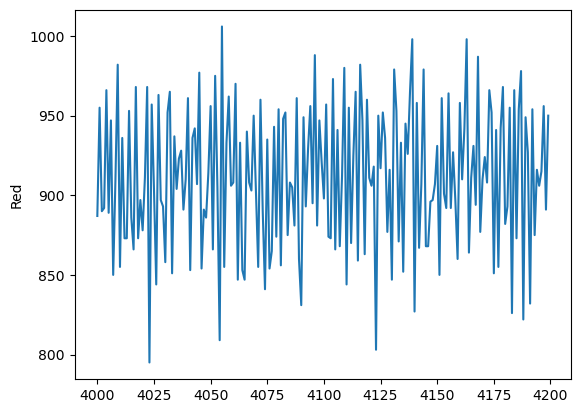

In [ ]:
sns.lineplot(data=df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 2]['Red'][0:200])

In [ ]:
plt.plot(x,df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 1]['Red'][0:200],label = "1")
plt.plot(x,df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 2]['Red'][0:200],label = "2")
plt.plot(x,df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 3]['Red'][0:200],label = "3")
plt.plot(x,df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 4]['Red'][0:200],label = "4")
plt.plot(x,df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 5]['Red'][0:200],label = "5")
plt.plot(x,df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 8]['Red'][0:200],label = "8")
plt.plot(x,df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 16]['Red'][0:200],label = "16")
plt.plot(x,df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 32]['Red'][0:200],label = "32")
plt.plot(x,df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 64]['Red'][0:200],label = "64")
plt.plot(x,df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 128]['Red'][0:200],label = "128")
plt.plot(x,df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 255]['Red'][0:200],label = "255")
plt.legend()
plt.title('Comparing Brightness vs Pulse width and Sampling Frequency')
plt.show()

In [35]:
#looking at Sensor signals

RED1= df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 1]['Red']
IR1= df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 1]['IR']
GREEN1= df_max30101_69_200.loc[df_max30101_69_200['Brightness'] == 1]['Green']

x = df_max30101_69_200['Timestamp'].index

RED1_norm = (RED1 - RED1.mean())/ (RED1.max()-RED1.min())
IR1_norm = (IR1- IR1.mean())/ (IR1.max()-IR1.min())
GREEN1_norm = (GREEN1 - GREEN1.mean())/ (GREEN1.max()-GREEN1.min())



In [36]:
#Filtering Signal
RED_signal= signal.butter(2, [.5,8], btype="bandpass", fs=fs, output="sos")
RED_filt = signal.sosfilt(RED_signal, RED1_norm)

#Filtering Noise
#should we do a band stop? so capturing high and low noise? 
noise = signal.butter(2, [.5,8], btype="bandstop", fs=fs, output="sos")
RED_noise = signal.sosfilt(noise, RED1)